In [ ]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
import tensorflow_probability as tfp
from tqdm import tnrange, tqdm_notebook
import seaborn as sns
import tensorflow as tf
from scipy import stats
tfd=tfp.distributions
from tqdm import notebook
from scipy import optimize
from functools import partial
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%matplotlib inline

### Load Data

In [ ]:
np.random.seed(2020)

# generate weibull distribution parameter
shape=np.random.uniform(1,5,1000)
scale=np.random.uniform(0.5,2,1000)


# the full design matrix
x=np.c_[shape,scale]


y=(np.random.weibull(shape,size=1000)*scale).reshape(-1,1)


train_x=x[:700,:]
train_y=y[:700,:]

test_x=x[700:,:]
test_y=y[700:,:]

ntrain=len(train_x)
ntest=len(test_x)


#### normalization function

In [ ]:
##define a normalization function
def norm_data(train, test,norm=True):
    std_train=np.ones(train.shape[1])
    mu_train=np.zeros(train.shape[1])
    if(norm):
        std_train = np.std(train, 0)
        mu_train=np.mean(train,0)

    train=(train - np.full(train.shape, mu_train)) / \
            np.full(train.shape, std_train)
    test=(test - np.full(test.shape, mu_train)) / \
            np.full(test.shape, std_train)
    return train,test,mu_train,std_train

In [ ]:
train_x,test_x,_,_=norm_data(train_x,test_x,norm=False)
#train_y,_,muy,stdy=norm_data(train_y,test_y,norm=False)

### Ensemble method based of hetero regression(EN)

In [ ]:
class EN:
    def __init__(self,lr,tau):
        self.lr=lr
        self.tau=tau
    
    def model_musd(self,trainx,trainy,testx):
        #the model
        model=tf.keras.Sequential([
            tf.keras.layers.Dense(100,activation=tf.nn.elu),
            tf.keras.layers.BatchNormalization(axis=-1),
            tf.keras.layers.Dense(50,activation=tf.nn.elu),
            tf.keras.layers.BatchNormalization(axis=-1),
            tf.keras.layers.Dense(1+1),
            tfp.layers.DistributionLambda(
            lambda t:tfd.Normal(loc=t[...,:1],
            scale=tf.math.softplus(self.tau*t[...,1:])+0.001)),
        ])

        #the loss
        negloglik = lambda y, p_y: -p_y.log_prob(y)

        #the model fitting for 5 models
        mut=np.empty(len(testx))
        sdt=np.empty(len(testx))
        for i in notebook.tnrange(5):
            model.compile(optimizer=tf.optimizers.Adam(self.lr),loss=negloglik)
            model.fit(trainx,trainy,epochs=500,batch_size=128,verbose=0)
            yhatt=model(testx)
            mu1=np.array(yhatt.mean()).ravel()
            sd1=np.array(yhatt.stddev()).ravel()
            mut=np.c_[mut,mu1]
            sdt=np.c_[sdt,sd1]

        sdt=sdt[:,1:]
        mut=mut[:,1:]


        #the averaged mean and sd for the ensemble model
        muhat=np.mean(mut,1)
        sighat=np.sqrt(np.mean(sdt**2+mut**2,1)-muhat**2)
        return muhat, sighat


#### 5-fold cross validation for parameter tuning

In [ ]:
lrval=[1.e-4,5.e-4,1.e-3]
tauval=[0.01,0.05,0.1]
hyperparam=np.zeros((9,2))
hyperparam[:,0]=np.repeat(lrval,3)
hyperparam[:,1]=np.tile(tauval,3)

In [ ]:
## create 5 folds
id = np.arange(len(train_x))
kf = KFold(n_splits=5)
tuneresult=[]


for i in range(len(hyperparam)):
    
    ## tuning parameter
    lrtmp=hyperparam[i,0]
    tautmp=hyperparam[i,1]

    for trainid, testid in kf.split(id):
        entmp=EN(lrtmp,tautmp)
        mutmp,stdtmp=entmp.model_musd(train_x[trainid],train_y[trainid],train_x[testid])

        ## extract validation y
        testytmp=train_y[testid]
 
        ##likelihood
        low=np.quantile(testytmp,0.05)
        high=np.quantile(testytmp,0.95)
        itv=np.linspace(low,high,9)
        itv=np.append(-np.infty,itv)
        itv=np.append(itv,np.infty)
        #outcome1 belongs to which interval
        ids=np.zeros(len(testytmp))
        for i in range(10):
            ids=ids+1*(testytmp.ravel()>itv[i+1])
        ids=ids.astype('int')
        
        l=(itv[ids]-mutmp)/stdtmp
        r=(itv[ids+1]-mutmp)/stdtmp
        prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
        ll_est=np.log(prtmp+1.e-10)
        
        tuneresult.append(ll_est.mean())            



In [ ]:
list(zip([np.mean(tuneresult[i*5:(i+1)*5]) for i in range(9)],hyperparam))

[(-2.0069568174954275, array([0.0001, 0.01  ])),
 (-1.8897877657240123, array([0.0001, 0.05  ])),
 (-1.8669552003746417, array([0.0001, 0.1   ])),
 (-1.8807917187519174, array([0.0005, 0.01  ])),
 (-1.8456271283725996, array([0.0005, 0.05  ])),
 (-1.8499690678186433, array([0.0005, 0.1   ])),
 (-1.8514922374941427, array([0.001, 0.01 ])),
 (-1.855776189799998, array([0.001, 0.05 ])),
 (-1.843865849522111, array([0.001, 0.1  ]))]

### We choose lr=1e-3,tau=0.1 ad the best tunning parameter for model fitting

In [ ]:
ENmodel=EN(1.e-3,0.1)
enmu,enstd=ENmodel.model_musd(train_x,train_y,test_x)

### Evaluation

#### median by mae

In [ ]:
np.abs(enmu-test_y.ravel()).mean()

0.4003463027843474

#### Calibration

In [ ]:
per=np.linspace(0.02,0.98,8)


In [ ]:
#generate confidence interval estimated mean and std
enc=[]
enwidth=stats.norm.ppf(0.95)*2*enstd

per=np.linspace(0.02,0.98,8)
for i in per:
    lquantile=(stats.norm.ppf(0.5-i/2.)*enstd+enmu)
    rquantile=(stats.norm.ppf(0.5+i/2.)*enstd+enmu)
    enc.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))

l90=(stats.norm.ppf(0.5-0.9/2.)*enstd+enmu)
r90=(stats.norm.ppf(0.5+0.9/2.)*enstd+enmu)
np.mean((test_y.ravel()<r90.ravel())*(test_y.ravel()>l90.ravel()))    

0.9033333333333333

In [ ]:
enc,np.abs(enc-per).mean()

([0.016666666666666666,
  0.15666666666666668,
  0.33666666666666667,
  0.48,
  0.6,
  0.71,
  0.86,
  0.9833333333333333],
 0.018869047619047567)

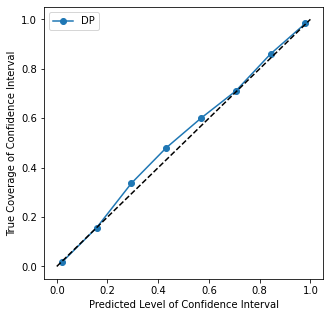

In [ ]:
plt.plot(per,enc,'o-',label='DP')
plt.xlabel('Predicted Level of Confidence Interval')
plt.ylabel('True Coverage of Confidence Interval')
plt.legend()
plt.plot([0,1],[0,1],'k--')
fig = plt.gcf()
fig.set_size_inches(5,5)

Estimate survival probability beyond 1

In [ ]:
#true
tsuv1=1-stats.weibull_min.cdf(1,c=test_x[:,0],scale=test_x[:,1])

#cdf estimate by g
ensuv1=1.-(stats.norm.cdf((1.-enmu)/enstd))

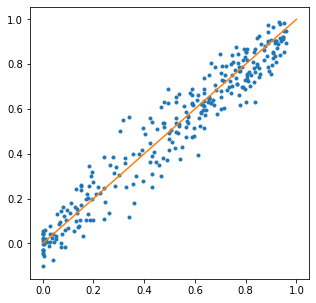

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(tsuv1,ensuv1,'.')

plt.plot([0,1],[0,1])

In [ ]:
np.save('ensuv_est',ensuv1)

#### log likelihood


In [ ]:
##likelihood
low=np.quantile(test_y,0.05)
high=np.quantile(test_y,0.95)
itv=np.linspace(low,high,9)
itv=np.append(-np.infty,itv)
itv=np.append(itv,np.infty)
#outcome1 belongs to which interval
id=np.zeros(len(test_y))
for i in range(10):
    id=id+1*(test_y.ravel()>itv[i+1])
id=id.astype('int')

In [ ]:
l=(itv[id]-enmu)/enstd
r=(itv[id+1]-enmu)/enstd
prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
ll_est=np.log(prtmp+1.e-10)
ll_est.mean()

-1.8761697763416756

#### Compare the generated distribution to groud truth for three random samples

In [ ]:
#generate sample
np.random.seed(3421)
samps=np.random.choice(len(test_x),3)

In [ ]:
samps

array([256, 102, 176])

In [ ]:
test_x[samps]

array([[1.50802122, 1.33651898],
       [4.02053328, 0.91622155],
       [2.05087322, 1.38208813]])

In [ ]:
yrange=xtmp=np.linspace(-2,7,5000)

In [ ]:
## mean and sd for dp sample
enmusd=np.c_[enmu,enstd][samps]
enmusd

array([[1.17574213, 0.84697947],
       [0.83520939, 0.26753966],
       [1.0244451 , 0.59786767]])

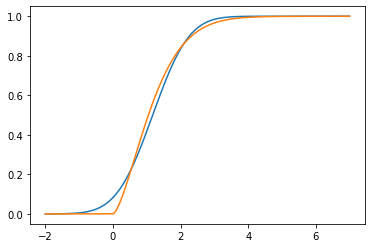

In [ ]:
i=samps[0]
tcdf=tcdf=stats.weibull_min.cdf(x=yrange,c=test_x[i,0],scale=test_x[i,1])
encdf=stats.norm.cdf((yrange-enmusd[0,0])/enmusd[0,1])

plt.plot(yrange,encdf)
plt.plot(yrange,tcdf)


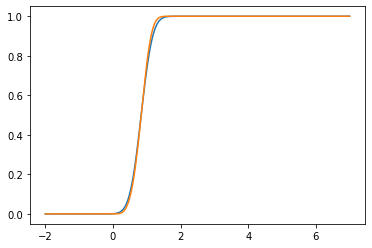

In [ ]:
i=samps[1]
tcdf=tcdf=stats.weibull_min.cdf(x=yrange,c=test_x[i,0],scale=test_x[i,1])
encdf=stats.norm.cdf((yrange-enmusd[1,0])/enmusd[1,1])

plt.plot(yrange,encdf)
plt.plot(yrange,tcdf)


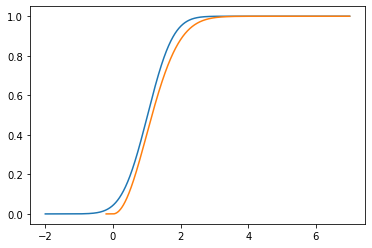

In [ ]:
i=samps[2]
tcdf=tcdf=stats.weibull_min.cdf(x=yrange,c=test_x[i,0],scale=test_x[i,1])
encdf=stats.norm.cdf((yrange-enmusd[2,0])/enmusd[2,1])

plt.plot(yrange,encdf)
plt.plot(yrange[1000:],tcdf[1000:])
